In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
import glob
from collections import OrderedDict

__Neural Network Library Import__

In [3]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.layers import LSTM, Embedding, RepeatVector, TimeDistributed, Masking, Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

Using TensorFlow backend.
C:\Users\spbhatkar.AHEAD\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\spbhatkar.AHEAD\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\spbhatkar.AHEAD\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\spbhatkar.AHEAD\A

In [4]:
data_path = 'G:\Sanit_Horizontal\Batteries\DataSets\LG18650\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020'

# Functions

__Function for seprating the required cycles__

In [5]:
def contain_list(file_name,list_name):
    
    dum = []
    
    for s in list_name:
        
        if s in file_name:
            
            dum = file_name
            break     
        
    return(dum)

__Function for getting only the required files__

In [6]:
def csv_list_find(data_path,folder,cycle):
    
    
    csv_file_path_list = []
    csv_file_list = []
    our_files = []
    folder = folder

    d = os.path.join(data_path,folder)
    
    if os.path.isdir(d):

            # csv files in the path
            csv_list = glob.glob(d + "/*.csv")
            
            for i in range(len(csv_list)):

                if (contain_list(csv_list[i],cycle)!= []):
                    
                    our_files.append(contain_list(csv_list[i],cycle))
        
    return our_files

__Function for getting the filtered list__

In [7]:
def filtered_file_list(csv_files,charge_cycle_files,test_drive_cycles):

    file_path = {}

    for file in csv_files:

        df = pd.read_csv(file, header=[25,26], index_col=0, parse_dates=True,nrows=26)
        file_path[str(df.first_valid_index())] = file

    od = OrderedDict(sorted(file_path.items()))
    filtered = od.copy()


    # File rearrange code
    
    is_previous_charge = False
    is_previous_discharge = False

    for key, value in od.items():

        if not is_previous_discharge and any(substring in value for substring in test_drive_cycles):
            is_previous_discharge = True 
            is_previous_charge = False

        elif not is_previous_charge and any(substring in value for substring in charge_cycle_files):
            if not is_previous_charge and not is_previous_discharge:
                filtered.pop(key)
            is_previous_charge = True
            is_previous_discharge = False

        elif is_previous_discharge and any(substring in value for substring in test_drive_cycles):
            filtered.pop(key)

        elif is_previous_charge and any(substring in value for substring in charge_cycle_files):
            filtered.pop(key)
            
    return (list(filtered.values()))

__Function for finding and filtering all the required files__

In [8]:
def data_file_path(data_path,dis_cycle,chg_cycle,folder_list):
    
    csv_files = []
    dum = []
    
    for i in range(len(folder_list)):
    
        dum = csv_list_find(data_path,folder_list[i],(dis_cycle + chg_cycle))

        csv_files.append(dum)

    csv_files = [file_list for file in csv_files for file_list in file]
    
    # Filtering only the required files
    filtered_file_path = filtered_file_list(csv_files,chg_cycle,dis_cycle)
    
    return filtered_file_path  

__Data Normalizaztion Function__

In [9]:
def data_normal(data_path,dis_cycle,chg_cycle,folder_list,resample_1hz,vi_averages):
    
    filtered_file_path = data_file_path(data_path,dis_cycle,chg_cycle,folder_list)

    for path in filtered_file_path:

        cycle = pd.read_csv(path, header=[25,26], index_col=0, parse_dates=True)
        cycle.drop(cycle.columns[-1],axis=1,inplace=True)
        cycle.columns = cycle.columns.droplevel(-1)

        # leave out 'PAU' rows from the cycle
        options = ['CHA', 'DCH', 'TABLE']
        cycle = cycle[cycle['Status'].isin(options)]

        # calculate 'Power'
        cycle['Power'] = cycle['Voltage'] * cycle['Current']

        # calculate SOC Percentage + downsample discharge cycles, upsample charge cycles
        # - DISCHARGE FILES
        if any(substring in path for substring in dis_cycle):
            max_discharge = abs(min(cycle['Capacity']))
            cycle['SoC Percentage'] = (cycle['Capacity'] + max_discharge)/max_discharge


            if resample_1hz:
                cycle = cycle.resample('1S').first()

        # - CHARGE FILES
        elif any(substring in path for substring in chg_cycle):
            max_charge = abs(max(cycle['Capacity']))
            cycle['SoC Percentage'] = (cycle['Capacity'])/max_charge

            if resample_1hz:
                cycle = cycle[~cycle.index.duplicated(keep='first')]
                cycle = cycle.resample('1S').ffill()


        # select required features
        parameters = cycle[['Voltage', 'Current', 'Temperature', 'Power', 'SoC Percentage']].copy()

        # calculate 'Voltage', 'Current' and 'Power' averages
        # 500 second rolling window which translates to rougly 500 data points for resampled data and 5000 for raw data
        rolling_window = 5000
        if vi_averages and resample_1hz:
          rolling_window = int(rolling_window / 10)

        if vi_averages:
          parameters['Voltage Average'] = parameters['Voltage'].rolling(rolling_window).mean()
          parameters['Current Average'] = parameters['Current'].rolling(rolling_window).mean()
          parameters['Power Average'] = parameters['Power'].rolling(rolling_window).mean()

        parameters.dropna(inplace = True)
        parameters.reset_index(drop=True, inplace=True)

        # merge datasets
        try:
            merged = pd.concat([merged, parameters], ignore_index=True)
        except:
            merged = parameters.copy()


    # scale (normalize) the dataset using mean normalization
    merged_norm = (merged-merged.mean())/merged.std()
    # min-max normalization
    # merged_norm = (merged - merged.min())/(merged.max() - merged.min())
    
    return (merged,merged_norm)

# Main Code

## User Inputs

In [10]:
# CSV files have the string mentioned in their name

charge_cycle_files = ['Charge']

train_temps = ['n10degC', '0degC', '10degC', '25degC']
train_drive_cycles = ['Mixed']

test_temps = ['n10degC', '0degC', '10degC', '25degC']
# test_temps = ['25degC']
test_drive_cycles = ['UDDS', 'HWFET', 'LA92', 'US06']

vi_averages = True
# resample_freq = 1
resample_1hz = True

## Normalized Dataset

In [11]:
# Normalized train data
train, train_norm = data_normal(data_path,train_drive_cycles,charge_cycle_files,test_temps,resample_1hz,vi_averages)

# Normalized test data
test, test_norm = data_normal(data_path,test_drive_cycles,charge_cycle_files,test_temps,resample_1hz,vi_averages)

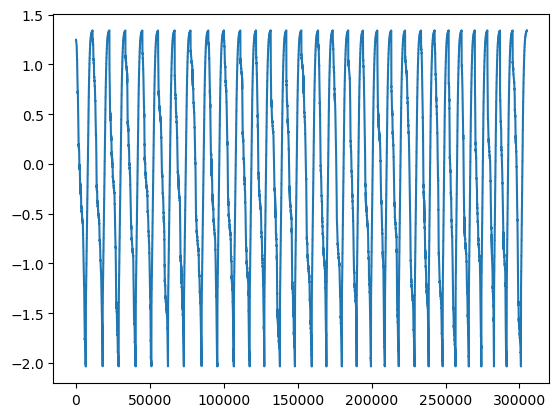

In [12]:
plt.plot(train_norm['SoC Percentage'])

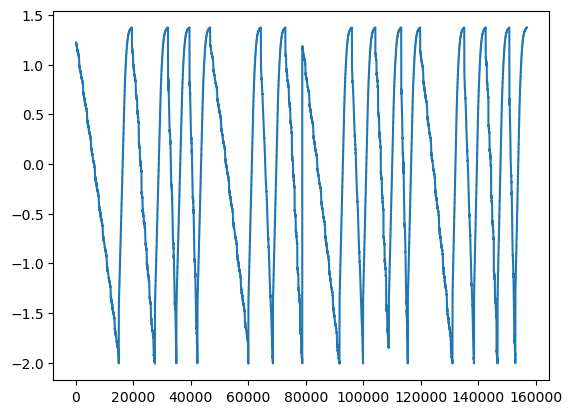

In [13]:
plt.plot(test_norm['SoC Percentage'])

# Neural Network Code

__Data Preprocessing__

In [40]:
train_data = train_norm.drop(['SoC Percentage'], axis = 1)
test_data = test_norm.drop(['SoC Percentage'], axis = 1)

train_label = train_norm['SoC Percentage']
test_label = test_norm['SoC Percentage']

In [41]:
# Reshaping the array

train_reshaped = np.array(train_data)
train_reshaped = train_reshaped.reshape((np.array(train_reshaped).shape[0],np.array(train_reshaped).shape[1],1))

train_label_reshaped = np.array(train_label)
train_label_reshaped = train_label_reshaped.reshape((np.array(train_reshaped).shape[0],1,1))


In [42]:
# Reshaping the array

test_reshaped = np.array(test_data)
test_reshaped = test_reshaped.reshape((np.array(test_reshaped).shape[0],np.array(test_reshaped).shape[1],1))

test_label_reshaped = np.array(test_label)
test_label_reshaped = test_label_reshaped.reshape((np.array(test_reshaped).shape[0],1,1))


__Model Definition__

In [16]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32,
                           kernel_size=(7,),
                           activation='relu'))

cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(1))

cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')


In [19]:
history = cnn_model.fit(train_reshaped, train_label_reshaped, 
                                epochs=25, 
                                batch_size=32, 
                                verbose=1,
                                validation_split=0.2,
                               )


Train on 244025 samples, validate on 61007 samples
Epoch 1/25
244025/244025 [==============================] - 11s 45us/step - loss: 0.0443 - val_loss: 0.0843
Epoch 2/25
244025/244025 [==============================] - 11s 43us/step - loss: 0.0319 - val_loss: 0.0782
Epoch 3/25
244025/244025 [==============================] - 11s 44us/step - loss: 0.0306 - val_loss: 0.0786
Epoch 4/25
244025/244025 [==============================] - 11s 44us/step - loss: 0.0300 - val_loss: 0.0792
Epoch 5/25
244025/244025 [==============================] - 11s 44us/step - loss: 0.0295 - val_loss: 0.0703
Epoch 6/25
244025/244025 [==============================] - 11s 43us/step - loss: 0.0291 - val_loss: 0.0800
Epoch 7/25
244025/244025 [==============================] - 11s 44us/step - loss: 0.0286 - val_loss: 0.0701
Epoch 8/25
244025/244025 [==============================] - 10s 39us/step - loss: 0.0284 - val_loss: 0.0732
Epoch 9/25
244025/244025 [==============================] - 10s 42us/step - loss: 0.

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

## Visualization

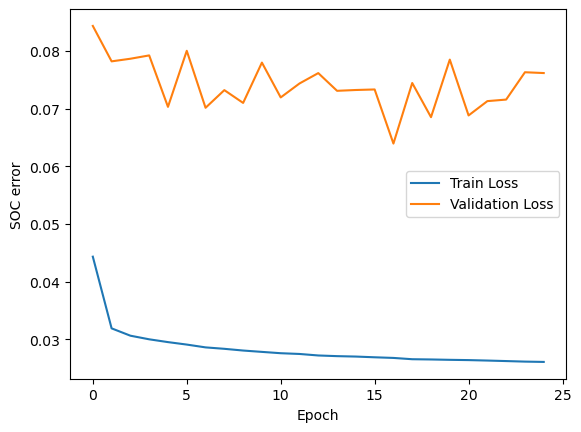

In [36]:
plt.plot(hist['loss'], label = 'Train Loss')
plt.plot(hist['val_loss'], label = 'Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('SOC error')
plt.show()

__Cross Validation__


In [44]:
test_results = {}
test_results['cnn_model'] = cnn_model.evaluate(test_reshaped, test_label_reshaped, verbose=2)

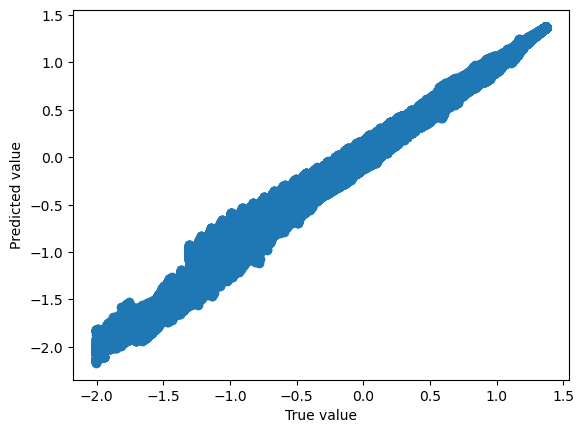

In [57]:
test_predict = cnn_model.predict(test_reshaped)
plt.scatter(test_label_reshaped,test_predict)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

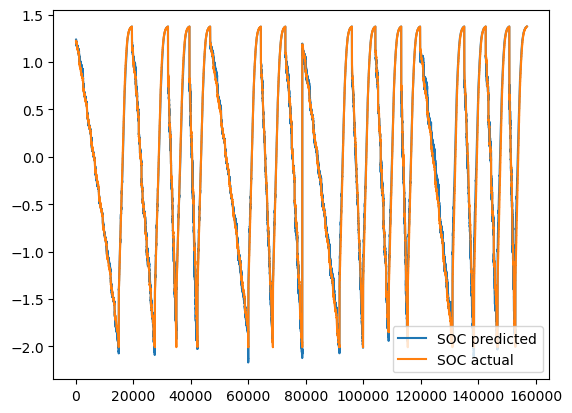

In [67]:
plt.plot(test_predict.flatten(), label = 'SOC predicted')
plt.plot(test_label_reshaped.flatten(), label = 'SOC actual')
plt.legend()
plt.show()


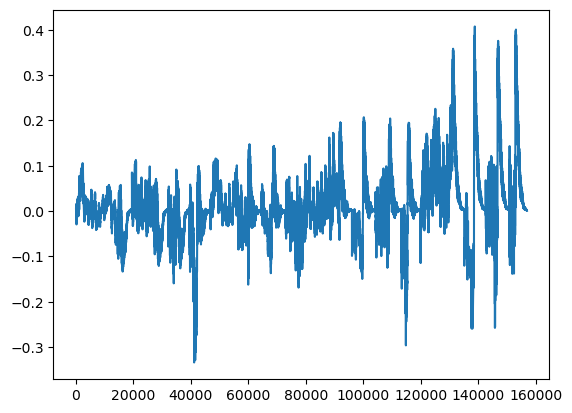

In [68]:
plt.plot(test_predict.flatten()-test_label_reshaped.flatten())

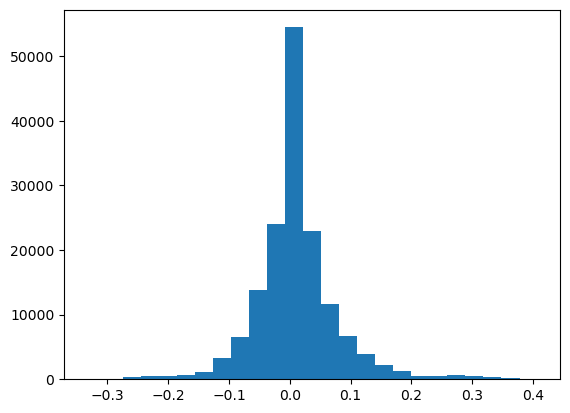

In [71]:
plt.hist(test_predict.flatten()-test_label_reshaped.flatten(), bins = 25)
plt.show()

## Saving the model

In [72]:
cnn_model.save('cnn_model')

## Retrieve and reuse the model

In [78]:
import json


In [81]:
from keras.models import model_from_json

In [82]:
cnn_model = cnn_model.to_json()

In [85]:
with open('cnn_model.json','w') as json_file:
    
    json_file.write(cnn_model)